# Random Forest Opportunity Classifier

This notebook trains a supervised **Random Forest opportunity classifier** on the
5% GMM overextension candidates. The goal is to predict the **probability of
profitable mean reversion** (label = +1) vs. non‑reversion (labels −1 and 0)
using a **day‑level LODO scheme** on the four training days (Oct 2, 3, 6, 7)
and evaluate on the held‑out test day (Oct 8), producing report‑ready metrics,
plots, and tables.


In [1]:
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('..')
print(f"Working directory: {os.getcwd()}")

# Config
RANDOM_STATE = 42
DATA_PATH = Path("data/gmm/gmm_candidates_5pct.parquet")

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("rf_notebook")

np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


Working directory: c:\Users\doqui\OneDrive\Documents\cs4641-131-project


In [2]:
# Load 5% GMM candidates and construct features/labels

assert DATA_PATH.exists(), f"Candidates file not found: {DATA_PATH}"

cands = pd.read_parquet(DATA_PATH)
logger.info(f"Loaded candidates: {len(cands):,} rows")

# Standardize date type and derive day key
cands["date"] = pd.to_datetime(cands["date"])
cands["day"] = cands["date"].dt.date

# Keep only overextension candidates according to 5% threshold
if "gmm_is_candidate" in cands.columns:
    cands = cands.loc[cands["gmm_is_candidate"]].copy()
    logger.info(f"Filtered to 5% GMM candidates: {len(cands):,} rows")

# Drop rows without labels
if "label" not in cands.columns:
    raise ValueError("Expected 'label' column in candidates data.")

cands = cands.dropna(subset=["label"]).copy()

# Binary target: profitable reversion (+1) vs non-reversion (-1 or 0)
cands["y"] = (cands["label"] == 1).astype(int)

# Feature matrix
feature_cols = [col for col in cands.columns if col.startswith("feat_")]
if not feature_cols:
    raise ValueError("No feature columns starting with 'feat_' found in candidates data.")

# Drop rows with NaNs in features
before = len(cands)
cands = cands.dropna(subset=feature_cols + ["y"]).copy()
logger.info(f"Dropped {before - len(cands):,} rows with NaNs in features/target; remaining {len(cands):,}.")

X = cands[feature_cols].to_numpy(dtype=float)
y = cands["y"].to_numpy(dtype=int)
days = cands["day"].to_numpy()

unique_days = sorted(pd.unique(days))
logger.info(f"Unique days in RF dataset: {unique_days}")

# Train / test split by day
if len(unique_days) != 5:
    logger.warning("Expected 5 unique days; got %d", len(unique_days))

train_days = unique_days[:-1]
test_day = unique_days[-1]
logger.info(f"Train days: {train_days} | Test day: {test_day}")

train_mask = np.isin(days, train_days)
test_mask = days == test_day

X_train_raw, y_train = X[train_mask], y[train_mask]
X_test_raw, y_test = X[test_mask], y[test_mask]

# Standardize features: fit on train, transform both train and test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

logger.info("Standardized features using StandardScaler (fit on train, transform train+test)")
logger.info(f"Train samples: {X_train.shape[0]:,} | Test samples: {X_test.shape[0]:,}")
logger.info("Class balance (train): %s", pd.Series(y_train).value_counts(normalize=True).to_dict())
logger.info("Class balance (test): %s", pd.Series(y_test).value_counts(normalize=True).to_dict())


2025-11-28 13:23:14,710 [INFO] Loaded candidates: 46,355 rows
2025-11-28 13:23:14,746 [INFO] Filtered to 5% GMM candidates: 2,347 rows
2025-11-28 13:23:14,751 [INFO] Dropped 0 rows with NaNs in features/target; remaining 2,347.
2025-11-28 13:23:14,755 [INFO] Unique days in RF dataset: [datetime.date(2025, 10, 2), datetime.date(2025, 10, 3), datetime.date(2025, 10, 6), datetime.date(2025, 10, 7), datetime.date(2025, 10, 8)]
2025-11-28 13:23:14,757 [INFO] Train days: [datetime.date(2025, 10, 2), datetime.date(2025, 10, 3), datetime.date(2025, 10, 6), datetime.date(2025, 10, 7)] | Test day: 2025-10-08
2025-11-28 13:23:14,761 [INFO] Standardized features using StandardScaler (fit on train, transform train+test)
2025-11-28 13:23:14,761 [INFO] Train samples: 1,890 | Test samples: 457
2025-11-28 13:23:14,766 [INFO] Class balance (train): {1: 0.5095238095238095, 0: 0.49047619047619045}
2025-11-28 13:23:14,768 [INFO] Class balance (test): {1: 0.5142231947483589, 0: 0.48577680525164113}


In [3]:
# Helper to compute standard classification metrics

def compute_classification_metrics(y_true, y_pred, y_proba):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    # ROC-AUC requires both classes present; guard for edge cases
    try:
        metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
    except ValueError:
        metrics["roc_auc"] = np.nan
    return metrics


In [4]:
# Hyperparameter tuning with day-level LODO CV on the four training days

from itertools import product

train_days_array = np.array(train_days)
train_day_values = np.unique(train_days_array)

# grid for Random Forest hyperparameters
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10],
    "min_samples_leaf": [5, 10],
    "max_features": ["sqrt", None],
}


def run_lodo_cv_for_params(params):
    """Run LODO CV across train days for a given RF configuration.
    
    Note: We apply StandardScaler within each fold to avoid data leakage.
    Fit scaler on the fold's training data, transform both train and val.
    """
    cv_rows = []
    day_mask_train = days[train_mask]  # days for train subset only

    for val_day in train_day_values:
        val_mask = day_mask_train == val_day
        tr_mask = day_mask_train != val_day

        # Get raw (unstandardized) data for this fold
        X_tr_raw, y_tr = X_train_raw[tr_mask], y_train[tr_mask]
        X_val_raw, y_val = X_train_raw[val_mask], y_train[val_mask]

        # Standardize within the fold (fit on fold train, transform both)
        fold_scaler = StandardScaler()
        X_tr = fold_scaler.fit_transform(X_tr_raw)
        X_val = fold_scaler.transform(X_val_raw)

        logger.info(
            "LODO fold (params=%s): val_day=%s | train=%d | val=%d",
            params,
            val_day,
            X_tr.shape[0],
            X_val.shape[0],
        )

        rf = RandomForestClassifier(
            n_jobs=-1,
            random_state=RANDOM_STATE,
            **params,
        )

        rf.fit(X_tr, y_tr)
        y_val_pred = rf.predict(X_val)
        y_val_proba = rf.predict_proba(X_val)[:, 1]

        fold_metrics = compute_classification_metrics(y_val, y_val_pred, y_val_proba)
        cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])

        row = {
            "val_day": val_day,
            "n_val": int(len(y_val)),
            "cm_00": int(cm[0, 0]),
            "cm_01": int(cm[0, 1]),
            "cm_10": int(cm[1, 0]),
            "cm_11": int(cm[1, 1]),
            **params,
            **fold_metrics,
        }
        cv_rows.append(row)

    df = pd.DataFrame(cv_rows)
    mean_scores = {
        "mean_accuracy": df["accuracy"].mean(),
        "mean_precision": df["precision"].mean(),
        "mean_recall": df["recall"].mean(),
        "mean_f1": df["f1"].mean(),
        "mean_roc_auc": df["roc_auc"].mean(),
    }
    return df, mean_scores


# Grid search over the small hyperparameter grid using LODO CV
best_params = None
best_score = -np.inf
best_cv_results_df = None

tuning_rows = []

for n_estimators, max_depth, min_samples_leaf, max_features in product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["min_samples_leaf"],
    param_grid["max_features"],
):
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
    }

    logger.info("Evaluating params: %s", params)
    cv_df, mean_scores = run_lodo_cv_for_params(params)

    tuning_rows.append({**params, **mean_scores})

    # Use mean F1 as primary selection metric
    if mean_scores["mean_f1"] > best_score:
        best_score = mean_scores["mean_f1"]
        best_params = params
        best_cv_results_df = cv_df

# Summary of tuning results across all hyperparameter configurations
tuning_results_df = pd.DataFrame(tuning_rows).sort_values("mean_f1", ascending=False)

print("Hyperparameter tuning results (sorted by mean F1 over LODO folds):")
display(tuning_results_df)

print(f"\nSelected best params (by mean F1): {best_params}")

# Per-fold metrics for the best configuration
cv_results_df = best_cv_results_df.copy()

# Summary (mean/std across folds for the best params)
summary_stats = {}
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    summary_stats[metric + "_mean"] = cv_results_df[metric].mean()
    summary_stats[metric + "_std"] = cv_results_df[metric].std(ddof=1)

cv_summary_df = pd.DataFrame([summary_stats])

print("\nLODO CV metrics by validation day (best params, train days only):")
display(cv_results_df)

print("\nLODO CV summary (mean ± std over train days, best params):")
display(cv_summary_df)


2025-11-28 13:23:32,329 [INFO] Evaluating params: {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
2025-11-28 13:23:32,332 [INFO] LODO fold (params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'}): val_day=2025-10-02 | train=1183 | val=707
2025-11-28 13:23:32,852 [INFO] LODO fold (params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'}): val_day=2025-10-03 | train=1622 | val=268
2025-11-28 13:23:33,433 [INFO] LODO fold (params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'}): val_day=2025-10-06 | train=1529 | val=361
2025-11-28 13:23:33,994 [INFO] LODO fold (params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': 'sqrt'}): val_day=2025-10-07 | train=1336 | val=554
2025-11-28 13:23:34,530 [INFO] Evaluating params: {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': None}
20

Hyperparameter tuning results (sorted by mean F1 over LODO folds):


,n_estimators,max_depth,min_samples_leaf,max_features,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_roc_auc
9,400,NaN,5,None,0.512135,0.530616,0.512127,0.509475,0.527856
13,400,10.0,5,None,0.507351,0.529220,0.519089,0.506150,0.527180
5,200,10.0,5,None,0.505192,0.527136,0.509176,0.501614,0.521922
0,200,NaN,5,sqrt,0.504859,0.524350,0.503790,0.499564,0.524543
15,400,10.0,10,None,0.505223,0.523465,0.518031,0.498580,0.528524
11,400,NaN,10,None,0.502887,0.520180,0.505891,0.496522,0.527303
1,200,NaN,5,None,0.501429,0.520312,0.495737,0.496245,0.522777
4,200,10.0,5,sqrt,0.504358,0.527930,0.510532,0.496125,0.522875
3,200,NaN,10,None,0.503077,0.522250,0.507018,0.495977,0.526025
7,200,10.0,10,None,0.503190,0.523624,0.512015,0.495498,0.526272



Selected best params (by mean F1): {'n_estimators': 400, 'max_depth': None, 'min_samples_leaf': 5, 'max_features': None}

LODO CV metrics by validation day (best params, train days only):


,val_day,n_val,cm_00,cm_01,cm_10,cm_11,n_estimators,max_depth,min_samples_leaf,max_features,accuracy,precision,recall,f1,roc_auc
0,2025-10-02,707,215,105,251,136,400,None,5,None,0.496464,0.564315,0.351421,0.433121,0.510013
1,2025-10-03,268,71,54,77,66,400,None,5,None,0.511194,0.550000,0.461538,0.501901,0.533259
2,2025-10-06,361,88,88,81,104,400,None,5,None,0.531856,0.541667,0.562162,0.551724,0.538821
3,2025-10-07,554,115,191,81,167,400,None,5,None,0.509025,0.466480,0.673387,0.551155,0.529333



LODO CV summary (mean ± std over train days, best params):


,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,0.512135,0.014663,0.530616,0.043768,0.512127,0.137712,0.509475,0.056005,0.527856,0.012516


In [5]:
# Fit final Random Forest on all training days with tuned hyperparameters and evaluate on held-out test day

# Use tuned best_params if available; otherwise fall back to a reasonable default
if "best_params" in globals() and best_params is not None:
    rf_final_params = best_params
else:
    rf_final_params = {
        "n_estimators": 400,
        "max_depth": 10,
        "min_samples_leaf": 10,
        "max_features": "sqrt",
    }

rf_final = RandomForestClassifier(
    n_jobs=-1,
    random_state=RANDOM_STATE,
    **rf_final_params,
)

rf_final.fit(X_train, y_train)

y_test_pred = rf_final.predict(X_test)
y_test_proba = rf_final.predict_proba(X_test)[:, 1]

# Test metrics and confusion matrix
test_metrics = compute_classification_metrics(y_test, y_test_pred, y_test_proba)
test_cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

print("Held-out test day metrics (Oct 8, 2025):")
test_metrics_df = pd.DataFrame([{
    "split": "test",
    "n_samples": int(len(y_test)),
    **test_metrics,
}])
display(test_metrics_df)

print("\nHeld-out test day confusion matrix (rows=true, cols=pred):")
test_cm_df = pd.DataFrame(
    test_cm,
    index=["True 0 (no reversion)", "True 1 (reversion)"],
    columns=["Pred 0", "Pred 1"],
)
display(test_cm_df)

rf_summary_table = pd.concat(
    [
        pd.DataFrame({"split": ["CV mean"], **{k: [v] for k, v in summary_stats.items() if k.endswith("_mean")}}),
        pd.DataFrame({"split": ["CV std"], **{k: [v] for k, v in summary_stats.items() if k.endswith("_std")}}),
        test_metrics_df,
    ],
    ignore_index=True,
)

print("\nSummary table (CV mean/std and test metrics) for report:")
display(rf_summary_table)


Held-out test day metrics (Oct 8, 2025):


,split,n_samples,accuracy,precision,recall,f1,roc_auc
0,test,457,0.525164,0.547368,0.442553,0.489412,0.535538



Held-out test day confusion matrix (rows=true, cols=pred):


,Pred 0,Pred 1
True 0 (no reversion),136,86
True 1 (reversion),131,104



Summary table (CV mean/std and test metrics) for report:


,split,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,n_samples,accuracy,precision,recall,f1,roc_auc
0,CV mean,0.512135,0.530616,0.512127,0.509475,0.527856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CV std,NaN,NaN,NaN,NaN,NaN,0.014663,0.043768,0.137712,0.056005,0.012516,NaN,NaN,NaN,NaN,NaN,NaN
2,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457.0,0.525164,0.547368,0.442553,0.489412,0.535538


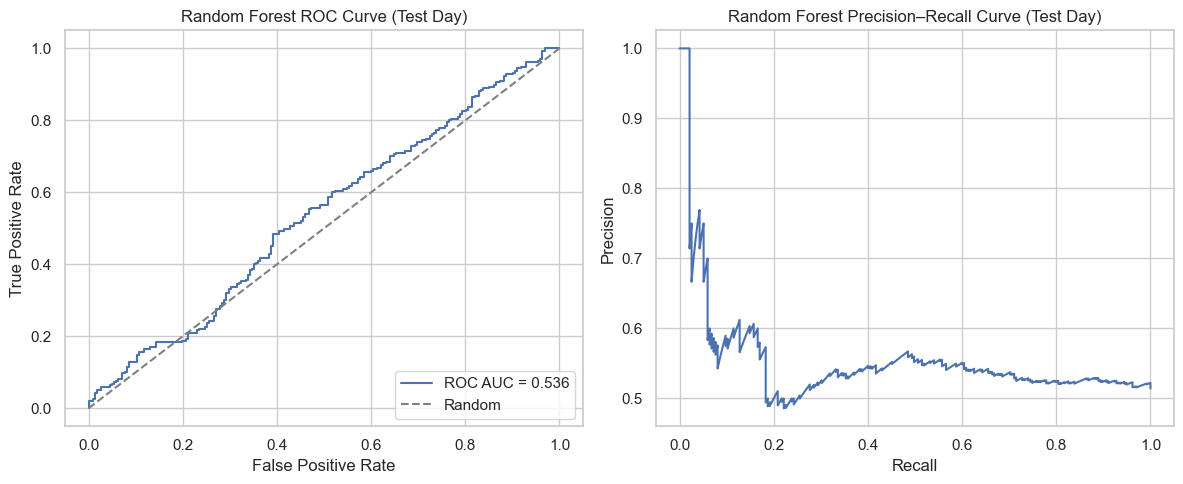

In [6]:
# ROC and Precision–Recall curves on held-out test day

fpr, tpr, roc_thresh = roc_curve(y_test, y_test_proba)
prec, rec, pr_thresh = precision_recall_curve(y_test, y_test_proba)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC curve
ax[0].plot(fpr, tpr, label=f"ROC AUC = {test_metrics['roc_auc']:.3f}")
ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Random Forest ROC Curve (Test Day)")
ax[0].legend(loc="lower right")

# PR curve
ax[1].plot(rec, prec)
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Random Forest Precision–Recall Curve (Test Day)")

plt.tight_layout()
plt.show()


Top feature importances (for table in report):


,feature,importance
5,feat_time_of_day,0.153986
8,feat_context_price_range,0.135081
7,feat_context_avg_volume,0.125172
0,feat_vwap_zscore,0.110977
1,feat_bollinger_position,0.110316
4,feat_relative_volume,0.107625
3,feat_momentum_5bar,0.092501
2,feat_momentum_3bar,0.085172
6,feat_context_bar_count,0.079171


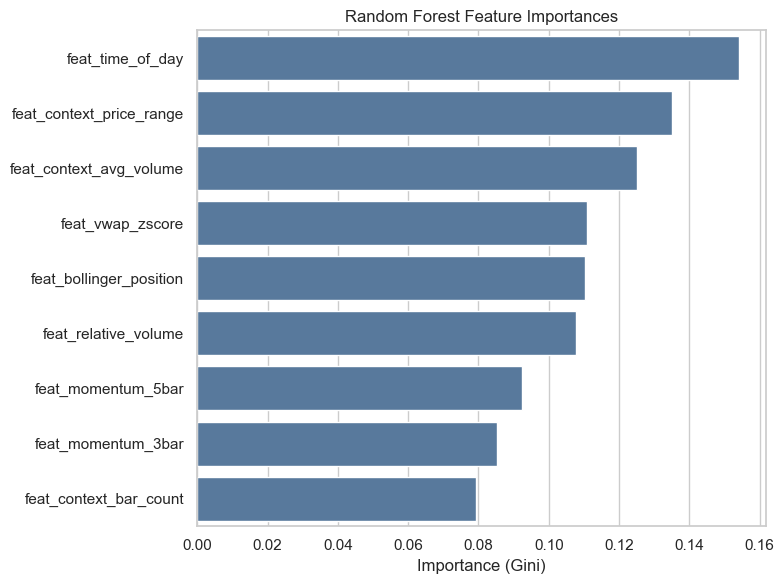

In [7]:
# Feature importance plot

importances = rf_final.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances,
}).sort_values("importance", ascending=False)

print("Top feature importances (for table in report):")
display(feat_imp_df)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp_df, x="importance", y="feature", color="#4c78a8")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance (Gini)")
plt.ylabel("")
plt.tight_layout()
plt.show()


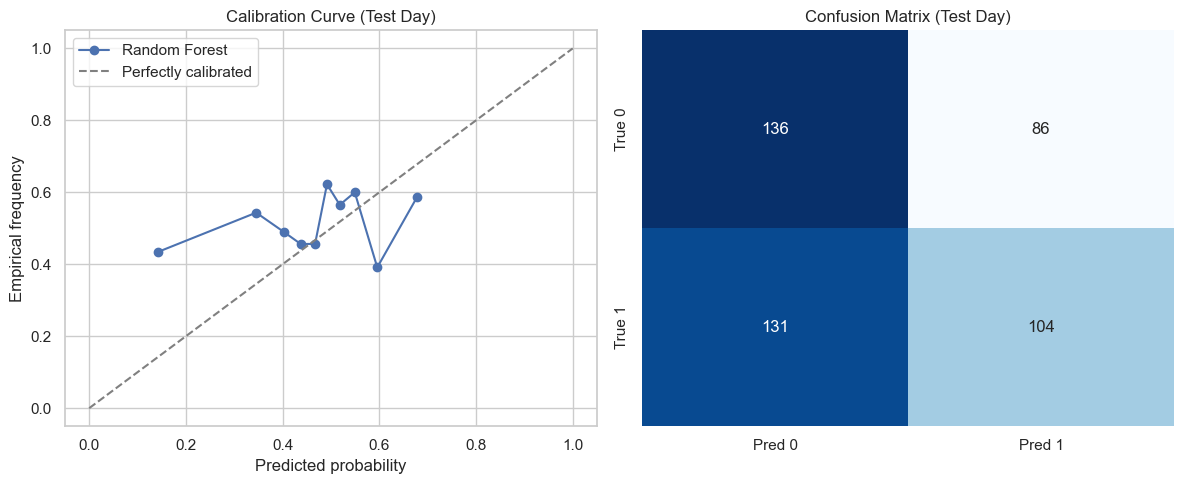

In [8]:
# Calibration curve and confusion matrix heatmap (test day)

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Calibration / reliability diagram
ax[0].plot(prob_pred, prob_true, marker="o", label="Random Forest")
ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
ax[0].set_xlabel("Predicted probability")
ax[0].set_ylabel("Empirical frequency")
ax[0].set_title("Calibration Curve (Test Day)")
ax[0].legend(loc="upper left")

# Confusion matrix heatmap
sns.heatmap(
    test_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"],
    ax=ax[1],
)
ax[1].set_title("Confusion Matrix (Test Day)")

plt.tight_layout()
plt.show()

C:\Users\doqui\AppData\Local\Temp\ipykernel_27624\1279201554.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax[1].boxplot(proba_by_class, labels=class_labels, patch_artist=True, widths=0.6)


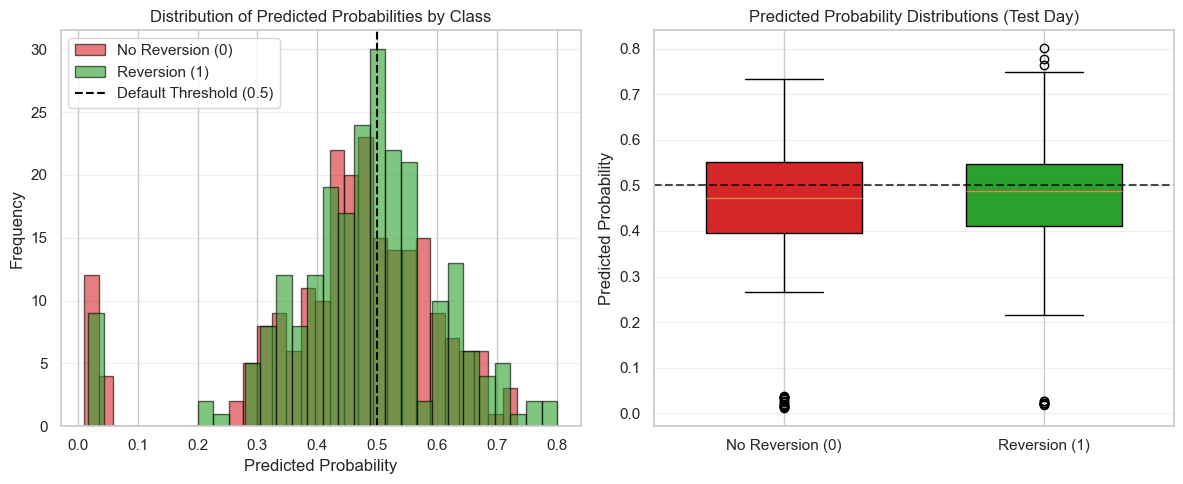


Predicted probability statistics by class (test day):
No Reversion (0): mean=0.451, median=0.472, std=0.154
Reversion (1):    mean=0.474, median=0.488, std=0.140

Overlap indicates weak separation between classes.


In [9]:
# Predicted probability distribution by class (test day)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram with overlay
ax[0].hist(y_test_proba[y_test == 0], bins=30, alpha=0.6, label="No Reversion (0)", color="#d62728", edgecolor="black")
ax[0].hist(y_test_proba[y_test == 1], bins=30, alpha=0.6, label="Reversion (1)", color="#2ca02c", edgecolor="black")
ax[0].axvline(0.5, color="black", linestyle="--", linewidth=1.5, label="Default Threshold (0.5)")
ax[0].set_xlabel("Predicted Probability")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Predicted Probabilities by Class")
ax[0].legend()
ax[0].grid(axis="y", alpha=0.3)

# Box plot
class_labels = ["No Reversion (0)", "Reversion (1)"]
proba_by_class = [y_test_proba[y_test == 0], y_test_proba[y_test == 1]]
bp = ax[1].boxplot(proba_by_class, labels=class_labels, patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor("#d62728")
bp['boxes'][1].set_facecolor("#2ca02c")
ax[1].axhline(0.5, color="black", linestyle="--", linewidth=1.5, alpha=0.7)
ax[1].set_ylabel("Predicted Probability")
ax[1].set_title("Predicted Probability Distributions (Test Day)")
ax[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nPredicted probability statistics by class (test day):")
print(f"No Reversion (0): mean={y_test_proba[y_test == 0].mean():.3f}, median={np.median(y_test_proba[y_test == 0]):.3f}, std={y_test_proba[y_test == 0].std():.3f}")
print(f"Reversion (1):    mean={y_test_proba[y_test == 1].mean():.3f}, median={np.median(y_test_proba[y_test == 1]):.3f}, std={y_test_proba[y_test == 1].std():.3f}")
print(f"\nOverlap indicates weak separation between classes.")


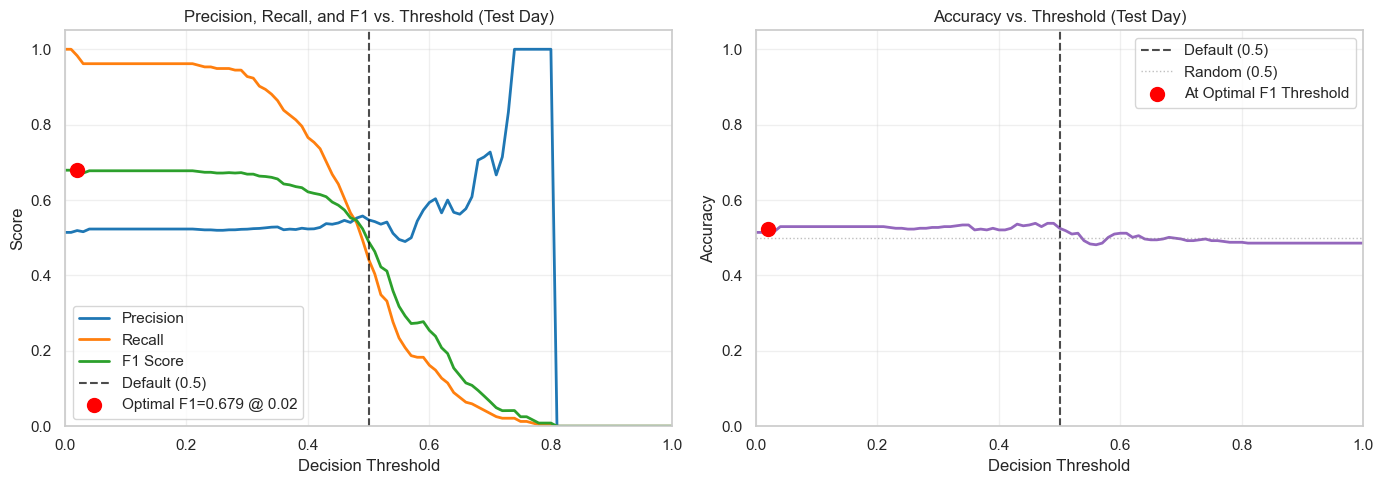


Optimal threshold for F1 score: 0.02
At this threshold:
  Precision: 0.519
  Recall:    0.983
  F1 Score:  0.679
  Accuracy:  0.523

At default threshold (0.5):
  Precision: 0.547
  Recall:    0.443
  F1 Score:  0.489
  Accuracy:  0.525


In [10]:
# Performance metrics vs decision threshold (test day)

# Compute precision, recall, and F1 at different thresholds
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1_scores = []
accuracies = []

for thresh in thresholds:
    y_pred_at_thresh = (y_test_proba >= thresh).astype(int)
    
    # Handle edge cases where no predictions or all predictions
    if y_pred_at_thresh.sum() == 0:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)
    else:
        precisions.append(precision_score(y_test, y_pred_at_thresh, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_at_thresh, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred_at_thresh, zero_division=0))
    
    accuracies.append(accuracy_score(y_test, y_pred_at_thresh))

# Convert to arrays
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)
accuracies = np.array(accuracies)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Precision, Recall, F1 vs Threshold
ax[0].plot(thresholds, precisions, label="Precision", linewidth=2, color="#1f77b4")
ax[0].plot(thresholds, recalls, label="Recall", linewidth=2, color="#ff7f0e")
ax[0].plot(thresholds, f1_scores, label="F1 Score", linewidth=2, color="#2ca02c")
ax[0].axvline(0.5, color="black", linestyle="--", linewidth=1.5, alpha=0.7, label="Default (0.5)")
ax[0].set_xlabel("Decision Threshold")
ax[0].set_ylabel("Score")
ax[0].set_title("Precision, Recall, and F1 vs. Threshold (Test Day)")
ax[0].legend(loc="best")
ax[0].grid(alpha=0.3)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1.05])

# Find optimal F1 threshold
optimal_idx = np.argmax(f1_scores)
optimal_thresh = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
ax[0].scatter([optimal_thresh], [optimal_f1], color="red", s=100, zorder=5, 
              label=f"Optimal F1={optimal_f1:.3f} @ {optimal_thresh:.2f}")
ax[0].legend(loc="best")

# Accuracy vs Threshold
ax[1].plot(thresholds, accuracies, linewidth=2, color="#9467bd")
ax[1].axvline(0.5, color="black", linestyle="--", linewidth=1.5, alpha=0.7, label="Default (0.5)")
ax[1].axhline(0.5, color="gray", linestyle=":", linewidth=1, alpha=0.5, label="Random (0.5)")
ax[1].scatter([optimal_thresh], [accuracies[optimal_idx]], color="red", s=100, zorder=5,
              label=f"At Optimal F1 Threshold")
ax[1].set_xlabel("Decision Threshold")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs. Threshold (Test Day)")
ax[1].legend(loc="best")
ax[1].grid(alpha=0.3)
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Print optimal threshold info
print(f"\nOptimal threshold for F1 score: {optimal_thresh:.2f}")
print(f"At this threshold:")
print(f"  Precision: {precisions[optimal_idx]:.3f}")
print(f"  Recall:    {recalls[optimal_idx]:.3f}")
print(f"  F1 Score:  {f1_scores[optimal_idx]:.3f}")
print(f"  Accuracy:  {accuracies[optimal_idx]:.3f}")

# Compare to default 0.5 threshold
default_idx = 50  # threshold = 0.5
print(f"\nAt default threshold (0.5):")
print(f"  Precision: {precisions[default_idx]:.3f}")
print(f"  Recall:    {recalls[default_idx]:.3f}")
print(f"  F1 Score:  {f1_scores[default_idx]:.3f}")
print(f"  Accuracy:  {accuracies[default_idx]:.3f}")


In [11]:
# Persist tuned Random Forest model, scaler, and per-event scores for downstream exit model

import json
from joblib import dump

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

rf_model_path = models_dir / "rf_opportunity.joblib"
rf_scaler_path = models_dir / "rf_opportunity_scaler.joblib"
rf_config_path = models_dir / "rf_opportunity_config.json"

rf_config = {
    "best_params": best_params if "best_params" in globals() else None,
    "feature_names": feature_cols,
    "train_days": [str(d) for d in train_days],
    "test_day": str(test_day),
    "cv_summary": summary_stats,
    "test_metrics": test_metrics,
    "preprocessing": "StandardScaler (fit on train days)",
}

dump(rf_final, rf_model_path)
dump(scaler, rf_scaler_path)
with rf_config_path.open("w") as f:
    json.dump(rf_config, f, indent=2)

print(f"Saved RF model to {rf_model_path}")
print(f"Saved RF scaler to {rf_scaler_path}")
print(f"Saved RF config to {rf_config_path}")

# Score all 5% GMM candidates with the tuned RF and persist to parquet
rf_data_dir = Path("data/randomForest")
rf_data_dir.mkdir(parents=True, exist_ok=True)

scores_path = rf_data_dir / "rf_opportunity_scores.parquet"

# X corresponds to all 5% GMM candidates (train + test) - apply scaler before scoring
X_scaled = scaler.transform(X)
proba_all = rf_final.predict_proba(X_scaled)[:, 1]
cands["rf_proba_reversion"] = proba_all

cands.to_parquet(scores_path, index=False)
print(f"Saved RF opportunity scores to {scores_path}")


Saved RF model to models\rf_opportunity.joblib
Saved RF scaler to models\rf_opportunity_scaler.joblib
Saved RF config to models\rf_opportunity_config.json
Saved RF opportunity scores to data\randomForest\rf_opportunity_scores.parquet
